In [379]:
%matplotlib inline

import os
import torch
import json
import h5py
import seaborn as sns
import numpy as np
import pandas as pd
from os.path import join
import matplotlib
import matplotlib.pyplot as plt

In [106]:
def invert_dict(d):
    return {v: k for k, v in d.items()}

In [107]:
def search_experiments(df, common_hypers):
    """ Find experiments that share identical hyper-parameters
    :param df: pd.DataFrame 
    :param common_hypers: dictionary of hyper-parameters
    :returns: indexes of df
    """
    n_exps = df.shape[0]
    same_exp_array = np.ones(n_exps, dtype=int)
    for id_ in range(n_exps):
        for k_, v_ in common_hypers.items():
            if type(v_) is dict:
                try:
                    same_exp = np.prod(np.array([df.iloc[id_][k_][k__] == v__
                                                 for k__, v__ in v_.items()]))
                except:
                    same_exp = False
            else:
                try:
                    same_exp = v_ == df.iloc[id_][k_]
                except:
                    same_exp = False
            if not same_exp:
                same_exp_array[id_] = same_exp
                break
    return np.squeeze(np.argwhere(same_exp_array))

In [305]:
def find_tmp_best(df, indexes, provide_info=False):
    """
    We report for this case the best temporary validation accuracy, evaluated
    on a subsample of 1k datapoints. If an experiment hasn't reached the 
    first evaluation (it is missing) we fix its temporary validation accuracy to -1.

    :param df: pd.DataFrame
    :param indexes: indexes for experiments that are comparable
    :return: tuple, index for the best experiment, best validation accuracy
    """
    path_list = [df["output_path"][k_] for k_ in indexes]
    max_list = []
    n_iters = []

    for id_, (index, path_) in enumerate(zip(indexes, path_list)):
        try:
            json_output = json.load(open(join(path_, "model.json"), "rb"))
            max_list.append((np.max(np.array(json_output["val_accs"]))))
            n_iters.append(json_output['val_accs_ts'][-1] / df.iloc[index]['hyper_opt']['num_iterations'])
        except:
            max_list.append(-1)
            n_iters.append(0)
    if provide_info:
        return indexes[np.argmax(max_list)], np.max(max_list), n_iters
    else:
        return indexes[np.argmax(max_list)], np.max(max_list)


def find_best_performance(df, indexes, seen_valid=True, seen_test=False):
    """ 
        We need to run the run_test function in the main, before proceeding.

    We evaluate the best validation accuracy, as the training is completed, and specify if the cross
    validation is done with respect to the seen distribution or unseen.
    
    :param seen_valid: if True, we consider the validation with same distribution as the training
    to perform cross validation, otherwise unseen distribution
    
    :param seen_test: if True, we return the test accuracy on seen distribution
    
    We return the index for the best model.
    """
    
    path_list = [df["output_path"][k_] for k_ in indexes]
    valid_list = []
    
    filename_valid = 'seen_valid_accuracy.npy' if seen_valid else 'valid_accuracy.npy'
    filename_test = 'seen_accuracy.npy' if seen_test else 'test_accuracy.npy'
    # print(filename_valid)
    for path_ in (path_list):
        valid_list.append(np.load(join(path_, filename_valid)))
    
    # print(np.max(valid_list))
    best_cv = indexes[np.argmax(valid_list)]
    
    test_accuracy = np.load(join(path_, filename_test))
    
    return indexes[np.argmax(valid_list)], test_accuracy

In [306]:
dct_hyper_method = {"find_w_bn": {"use_module": "find",
                                  "separated_stem": False,
                                  "separated_module": False,
                                  "separated_classifier": False,
                                  "stem_batchnorm": 1,
                                  "classifier_batchnorm": 1},
                    "res_w_bn": {"use_module": "residual",
                                 "separated_stem": False,
                                 "separated_module": False,
                                 "separated_classifier": False,
                                 "stem_batchnorm": 1,
                                 "classifier_batchnorm": 1},
                    "find_wo_bn": {"use_module": "find",
                                   "separated_stem": False,
                                   "separated_module": False,
                                   "separated_classifier": False,
                                   "stem_batchnorm": 0,
                                   "classifier_batchnorm": 0},
                    "res_wo_bn": {"use_module": "residual",
                                  "separated_stem": False,
                                  "separated_module": False,
                                  "separated_classifier": False,
                                  "stem_batchnorm": 0,
                                  "classifier_batchnorm": 0},
                    "half-sep_find": {"use_module": "find",
                                      "separated_stem": False,
                                      "separated_module": True,
                                      "separated_classifier": True,
                                      "stem_batchnorm": 0,
                                      "classifier_batchnorm": 0},
                    "sep_find": {"use_module": "find",
                                 "separated_stem": True,
                                 "separated_module": True,
                                 "separated_classifier": True,
                                 "stem_batchnorm": 0,
                                 "classifier_batchnorm": 0},
                    "sep_res": {"use_module": "residual",
                                "separated_stem": True,
                                "separated_module": True,
                                "separated_classifier": True,
                                "stem_batchnorm": 0,
                                "classifier_batchnorm": 0}
                   }

def pick_hyper_method(network, experiment_case):
    """ Use the key of dct_hyper_method to indicate one of the possible architectures
    Returns the dictionary for searching in the df
    """
    hyper_method = dct_hyper_method[network]
    if experiment_case == 1 or experiment_case == 2:
        hyper_method["feature_dim"] = [3,28,28]
    elif experiment_case == 3 or experiment_case == 4:
        hyper_method["feature_dim"] = [3,64,64]
    return hyper_method

# Read train.json

In [414]:
experiment_case = 1  # TODO: change based on experiment_k, with k=1,2,3,4
query = False # TODO: change to True in experiment_1 for the query case

path_results = "/om2/user/vanessad/understanding_reasoning/experiment_%i/results" % experiment_case

In [415]:
json_file = join(path_results, "train.json")
print(json_file)
df = pd.read_json(json_file).T
df

/om2/user/vanessad/understanding_reasoning/experiment_1/results/train.json


,id,output_path,train_completed,method_type,hyper_opt,hyper_arch,hyper_method,dataset
0,0,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.005, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_15', 'dataset_split': ..."
1,1,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.005, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_15', 'dataset_split': ..."
2,2,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.001, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_15', 'dataset_split': ..."
3,3,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.001, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_15', 'dataset_split': ..."
4,4,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.0001, 'architecture': None...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_15', 'dataset_split': ..."
...,...,...,...,...,...,...,...,...
415,415,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.001, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_23', 'dataset_split': ..."
416,416,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.0001, 'architecture': None...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_23', 'dataset_split': ..."
417,417,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.005, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_24', 'dataset_split': ..."
418,418,/om2/user/vanessad/understanding_reasoning/exp...,True,SHNMN,"{'learning_rate': 0.001, 'architecture': None,...","{'model_type': 'SHNMN', 'train_program_generat...","{'model_type': 'soft', 'use_module': 'find', '...","{'dataset_id': 'dataset_24', 'dataset_split': ..."


# Search for experiments with hyper-parameters

In [407]:
# visualization of the training curves 

dict_search = {"method_type": "SHNMN",
               # 'train_completed': True,
               "hyper_opt": {# 'early_stopping': False,
                             'num_iterations': 200000
                             # 'batch_size': 64,
                             # 'learning_rate': 0.001
                            },
               "hyper_method": pick_hyper_method('sep_find', experiment_case=experiment_case),
               "dataset": {"dataset_id": "dataset_3" ,
                           "experiment_case": 0 if query else 1 
                         }
                }

idxs = search_experiments(df, dict_search) 
idxs

array([198, 199, 200, 201, 202, 203])

198
LR 0.1
BS 64


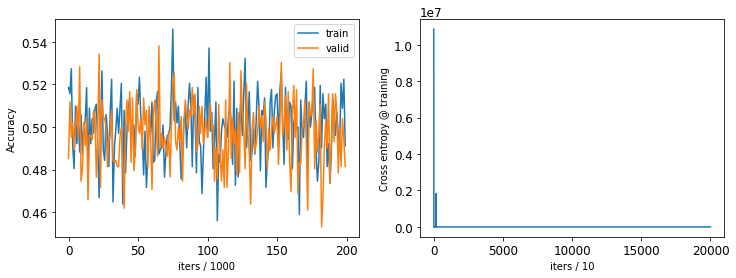

199
LR 0.01
BS 64


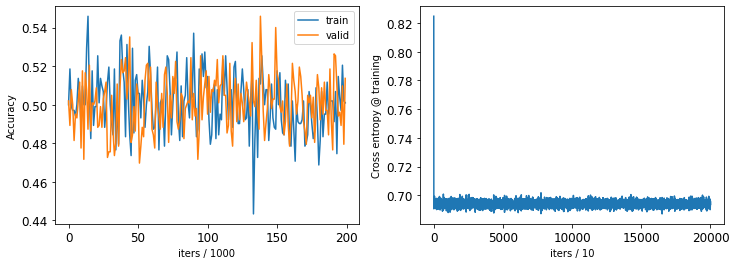

200
LR 0.005
BS 64


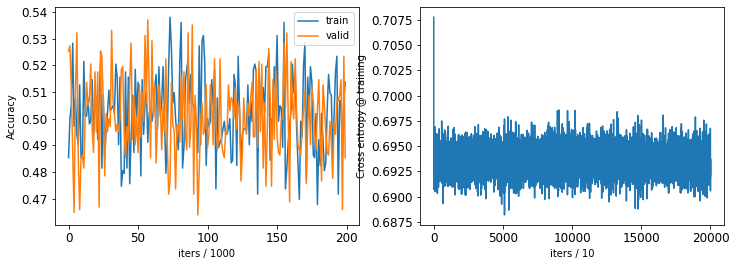

201
LR 0.001
BS 64


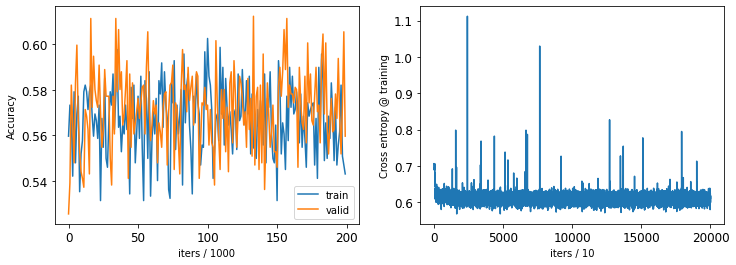

202
LR 0.0001
BS 64


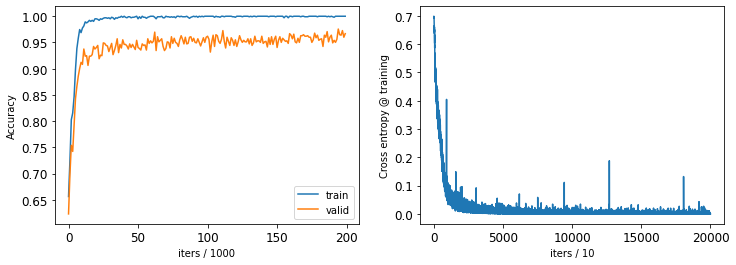

203
LR 1e-05
BS 64


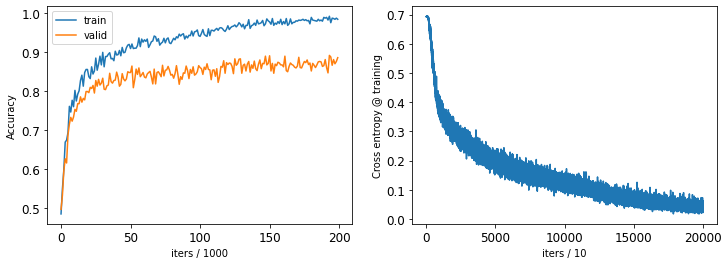

In [408]:
for id_ in idxs:
    print(id_)
    print("LR", df.iloc[id_]["hyper_opt"]["learning_rate"])
    print("BS", df.iloc[id_]["hyper_opt"]["batch_size"])
    output_path = df["output_path"][id_]
    try:
        json_output = json.load(open(join(output_path, "model.json"), "rb"))
    except:
        continue

    fig, ax = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)
    ax[0].plot(json_output["train_accs"], label="train")
    ax[0].plot(json_output["val_accs"], label="valid")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("iters / %i" % df.iloc[id_]['hyper_opt']['checkpoint_every'])
    ax[0].legend()
    # ax[0].set_ylim([0.9,1.])

    ax[1].plot(json_output["train_losses"])
    ax[1].set_ylabel("Cross entropy @ training")
    ax[1].set_xlabel("iters / %i" % df.iloc[id_]['hyper_opt']['record_loss_every']);
    plt.show()

# Evaluate accuracies

In [428]:
def eval_accuracy(dataset_id, 
                  exp_case=1, 
                  temp=False,
                  flag_seen_valid=True, 
                  flag_seen_test=False,
                  query=False):
    
    dataset_list = ["dataset_%i" %k_ for k_ in dataset_id]  # datasets 

    method_names = dct_hyper_method.keys()
    accuracies = np.zeros((len(dataset_list), len(method_names)))
    index_best_model = np.zeros((len(dataset_list), len(method_names)))
    if temp:
        info_exps = np.zeros((len(dataset_list), len(method_names)))
        
    for id_method, method_ in enumerate(method_names):
        
        dict_search = {"method_type": "SHNMN",
                       "hyper_method": pick_hyper_method(method_, experiment_case),
                       "dataset": {"experiment_case": 0 if query else 1}}
        
        for id_data, dataset_name in enumerate(dataset_list):
            dict_search["dataset"]["dataset_id"] = dataset_name
            # print(dict_search)
            idxs = search_experiments(df, dict_search)
            # print(idxs)
            
            if temp:
                id_, acc, info = find_tmp_best(df, idxs, provide_info=True)
                info_exps[id_data, id_method] = np.mean(info)
                index_best_model[id_data, id_method] = id_
            else:
                id_, acc = find_best_performance(df, 
                                                 idxs, 
                                                 seen_valid=flag_seen_valid, 
                                                 seen_test=flag_seen_test) 
                index_best_model[id_data, id_method] = id_

            # print(id_, acc)
            accuracies[id_data, id_method] = acc
            
    if temp:
        return accuracies, info_exps, dataset_list, method_names, index_best_model
    else:
        return accuracies, index_best_model

## Report temporary performance

In [418]:
dataset_id = np.arange(15,20)  # trial 1 for experiment 1

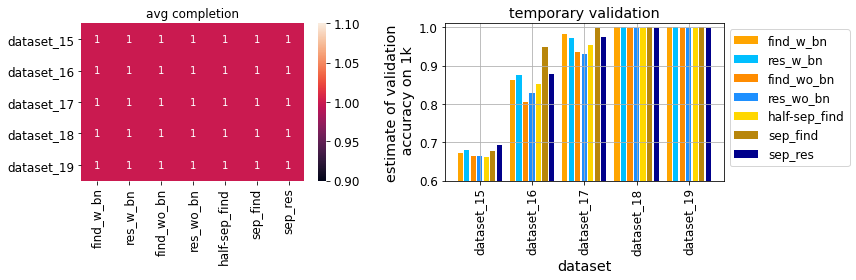

In [429]:
temp = True
tmp_valid, info, dlist, mlist, _ = eval_accuracy(dataset_id, 
                                                 exp_case=experiment_case, 
                                                 temp=temp)

metric = tmp_valid

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)


n_mts = len(method_names)
n_data = dataset_id.size
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
color_list = ["orange", "deepskyblue", 
              "darkorange", "dodgerblue",
              "gold", "darkgoldenrod",
              "darkblue"]
sns.heatmap(pd.DataFrame(data=info, index=dlist, columns=mlist), ax=ax[0], annot=True)
ax[0].set_title('avg completion')

for i, key_ in enumerate(method_names):
    ax[1].bar([n_mts*(k_)+i + k_ for k_ in range(n_data)], 
               metric[:, i], color=color_list[i], label=key_)
    
ax[1].set_title('temporary validation', fontsize='x-large')
ax[1].legend(fontsize="large", bbox_to_anchor=(1, 1), loc='upper left')

label_y = 'estimate of validation\n accuracy on 1k'
ax[1].set_ylabel(label_y, fontsize='x-large')
ax[1].set_xticks([len(mlist)*k_+len(mlist)//2+k_ for k_ in range(len(dlist))])
ax[1].set_xticklabels(dlist, rotation=90)
ax[1].set_xlabel('dataset', fontsize='x-large')

ax[1].grid()
ax[1].set_ylim([0.6,1.01])
plt.tight_layout()
plt.show()
plt.close()

## Final performance

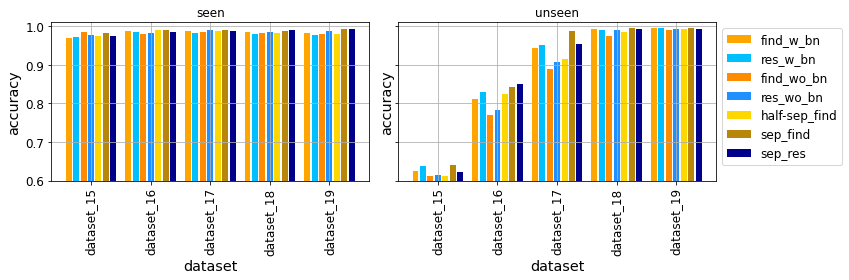

In [430]:
temp = False
seen_test, index_best_seen = eval_accuracy(dataset_id, 
                                           exp_case=experiment_case, 
                                           temp=temp,
                                           flag_seen_valid=True, 
                                           flag_seen_test=True)

unseen_test, _ = eval_accuracy(dataset_id, 
                               exp_case=experiment_case, 
                               temp=temp,
                               flag_seen_valid=True, 
                               flag_seen_test=False)

n_mts = len(method_names)
n_data = dataset_id.size
fig, ax = plt.subplots(figsize=(12, 4), sharey=True, ncols=2)
color_list = ["orange", "deepskyblue", 
              "darkorange", "dodgerblue",
              "gold", "darkgoldenrod",
              "darkblue"]

for j, metr_ in enumerate([seen_test, unseen_test]):
    for i, key_ in enumerate(method_names):
        ax[j].bar([n_mts*(k_)+i + k_ for k_ in range(n_data)], 
                   metr_[:, i], color=color_list[i], label=key_)
    ax[j].set_ylabel('accuracy', fontsize='x-large')
    ax[j].set_xticks([len(mlist)*k_+len(mlist)//2+k_ for k_ in range(len(dlist))])
    ax[j].set_xticklabels(dlist, rotation=90)
    ax[j].set_xlabel('dataset', fontsize='x-large')
    ax[j].grid()
    ax[j].set_ylim([0.6,1.01])

ax[0].set_title('seen')
ax[1].set_title('unseen')
ax[1].legend(fontsize="large", bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()
plt.close()

## Per question

In [483]:
category_idx = [k_ for k_ in range(10)]
color_idx = [k_ for k_ in range(10, 15)]
brightness_idx = [k_ for k_ in range(15, 18)]
size_idx = [k_ for k_ in range(18, 21)]

q_size_idx = [k_ for k_ in range(21, 25)]
q_color_idx = [k_ for k_ in range(25, 27)]
q_category_idx = [k_ for k_ in range(27, 29)]
q_brightness_idx = [k_ for k_ in range(29, 33)]
q_spatial_rel_idx = [k_ for k_ in range(33, 37)]

In [519]:
def map_attr_question_to_group(idx):
    """ Return the module id - where attributes,
    comparisons and relational questions are collected
    in subgroups.
    :param idx: identifier for the question
    """
    if idx in category_idx:
        return 0
    elif idx in color_idx:
        return 1
    elif idx in brightness_idx:
        return 2
    elif idx in size_idx:
        return 3
    else:
        raise ValueError("The inserted index is wrong")
    
def map_rel_question_to_group(idx):
    if idx in q_category_idx:
        return 0
    elif idx in q_color_idx:
        return 1
    elif idx in q_brightness_idx:
        return 2    
    if idx in q_size_idx:
        return 3
    elif idx in q_spatial_rel_idx:
        return 4
    else:
        raise ValueError("The inserted index is wrong")

In [527]:
pwd

'/rdma/vast-rdma/vast/cbmm/vanessad/understanding_reasoning/experiment_1/runs'

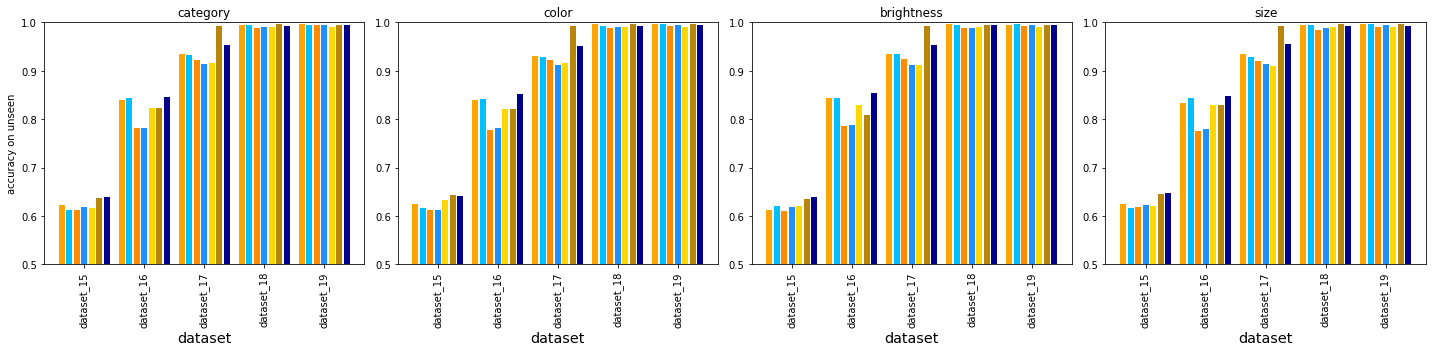

In [526]:
import seaborn as sns

title_list = ['category', 'color', 'brightness', 'size']

if experiment_case == 1 or experiment_case == 3:
    map_ = map_attr_question_to_group
    type_of_q = 4
elif experiment_case == 2:
    type_of_q = 4
    map_ = map_rel_question_to_group
else:
    type_of_q = 5
    map_ = map_rel_question_to_group
    title_list.append('spatial')
    
accuracy_per_question = np.zeros((type_of_q, len(dataset_id), len(method_names)))

for id_data, d_idx in enumerate(dataset_id):
    path_data = os.path.dirname(df.iloc[0]['dataset']['dataset_id_path'])
    vocab = json.load(open(join(df.iloc[0]['dataset']['dataset_id_path'], 'vocab.json'), 'rb'))
    questions = list(vocab['question_token_to_idx'].values())

    question_file = np.load(join(path_data, 'dataset_%i' % d_idx, 'questions_test.npy'))
    
    if experiment_case == 2 or experiment_case == 4:  # relational question only
        question_file = question_file[:,1]
        
    for id_method, method_ in enumerate(method_names):
        
        tmp_id = index_best_seen[id_data, id_method].astype(int)
        filename = join(df.iloc[tmp_id]["output_path"], "output.h5")
        file = h5py.File(filename, "r")
        correct = file["correct"][:]
        
        avg_factor = np.zeros(type_of_q)

        for id_question, q_ in enumerate(questions):
            id_q_ = np.argwhere(question_file == q_).squeeze()
            accuracy_per_question[map_(q_), id_data, id_method] += np.sum(correct[id_q_]) / id_q_.size
            avg_factor[map_(q_)] += 1
                
        accuracy_per_question[:, id_data, id_method] = np.divide(accuracy_per_question[:, id_data, id_method], 
                                                                 avg_factor)
        
fig, ax = plt.subplots(figsize=(20,5), ncols=type_of_q)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

for id__, acc_ in enumerate(accuracy_per_question):
    x_ax = x_ax = np.arange(0, len(method_names)*len(dataset_id), len(method_names)+1)
    for id_m_, methd_ in enumerate(method_names):
        ax[id__].bar(x_ax, acc_[:, id_m_], color=color_list[id_m_])
        x_ax += 1
    ax[id__].set_title(title_list[id__])
    ax[id__].set_xticks([len(mlist)*k_+len(mlist)//2+k_ for k_ in range(len(dlist))])
    ax[id__].set_xticklabels(dlist, rotation=90)
    ax[id__].set_xlabel('dataset', fontsize='x-large')
    ax[id__].set_ylim(0.5,1)
ax[0].set_ylabel('accuracy on unseen')
plt.tight_layout()

In [ ]:
acc_